In [3]:
from bokeh.plotting import figure, show

# Definindo os dados
celulas = ["3T3 Desbalanceado", "3T3 1:1", "3T3 1:5", "HEK Desbalanceado", "HEK 1:1", "HEK 1:5"]
metricas = ["BACC", "AUC", "F1", "MCC", "Precisão", "Especificidade", "Sensibilidade"]
acuracia = [
    [0.81, 0.8, 0.92],
    [0.8, 0.81, 0.9],
    [0.81, 0.81, 0.9],
    [0.83, 0.81, 0.9],
    [0.81, 0.81, 0.9],
    [0.9, 0.81, 0.9],
]
sensibilidade = [
    [0.63, 0.79, 0.84],
    [0.79, 0.81, 0.82],
    [0.81, 0.81, 0.82],
    [0.67, 0.81, 0.82],
    [0.81, 0.81, 0.82],
    [0.99, 0.81, 0.82],
]

# Criando o gráfico
p = figure(
    title="Comparação de células",
    x_range=celulas,
    y_axis_label="Métricas",
    width=1200,
    height=600,
)

# Plotando as linhas de acurácia
for i, celula in enumerate(celulas):
    p.line(
        x=[celula],
        y=acuracia[i],
        line_width=2,
        color="blue",
        alpha=0.8,
        legend_label=f"Acuracy - {celula}",
    )

# Plotando as linhas de sensibilidade
for i, celula in enumerate(celulas):
    p.line(
        x=[celula],
        y=sensibilidade[i],
        line_width=2,
        color="red",
        alpha=0.8,
        legend_label=f"Sensibility - {celula}",
    )

# Adicionando legendas
p.add_layout(p.legend[0], "above")

# Adicionando marcadores para os pontos
p.circle(
    x=celulas,
    y=[metricas[i] for i in range(len(acuracia[0]))],
    size=10,
    color="black",
    fill_color="white",
    line_color="black",
)

# Ajustando os rótulos dos eixos x e y
p.xaxis.major_label_orientation = 1.0
p.yaxis.major_label_orientation = 1.1

# Mostrando o gráfico
show(p)



In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from pathlib import Path

from rdkit import Chem
from chembl_structure_pipeline import standardizer
import rdkit.Chem.MolStandardize.rdMolStandardize as rdMolStandardize
from rdkit.Chem import PandasTools
from rdkit.Chem import inchi as rd_inchi
from molvs import standardize_smiles
from molvs import Standardizer

[08:42:42] Initializing Normalizer


In [24]:
smile = "OCCN1CCN(CCCN2C3=CC=CC=C3SC3=CC=C(C=C23)C(F)(F)F)CC1 |c:13,15,21,t:11,19,23|"

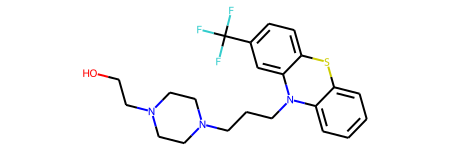

In [26]:
mol = Chem.MolFromSmiles(smile)
mol

In [3]:
file = Path(r"D:\OneDrive\Documentos\LabMol\IC-Skin\DADOS\Raw\Skin_data_LLNA_smilesok_converted.xlsx")
df  = pd.read_excel(str(file))
save_path = r"C:\Users\LabMo\Desktop"

file_name = file.name
initial_len = len(df)
print(f"Number of molecules: {initial_len}")

Number of molecules: 3319


In [4]:
df

,CAS No,Canonical SMILES,LLNA_EC3,"LLNA (EPA,GHS)",binary,Source
0,18479-49-7,CC(C)CCCC(C)(O)C=C,NaN,0,0,ECHA
1,93-84-5,[O-][N+](=O)c1ccc2NC(=O)Nc2c1,NaN,0,0,ECHA
2,38725-13-2,CC(C)CCCCCCN(CCCCCCC(C)C)CCCCCCC(C)C,NaN,1B,1,ECHA
3,49701-24-8,CN[S](=O)(=O)c1cc(OC)c(N)cc1OC,NaN,0,0,ECHA
4,3874-54-2,Fc1ccc(cc1)C(=O)CCCCl,NaN,NaN,1,ECHA
...,...,...,...,...,...,...
3314,122-78-1,O=CCc1ccccc1,4.7,0,0,CosEU
3315,122-78-1,O=CCc1ccccc1,3.0,1B,1,CosEU
3316,122-78-1,O=CCc1ccccc1,8.8,0,0,CosEU
3317,17369-59-4,CC/C=C/1OC(=O)c2ccccc12,3.7,0,0,CosEU


In [ ]:
print(f"Working on {file_name} ...")
df = df.loc[:, ['CAS No', 'PUBCHEM_ACTIVITY_OUTCOME', 'PUBCHEM_CID']]
df = df.rename(columns={'PUBCHEM_EXT_DATASOURCE_SMILES':'Molecule', 'PUBCHEM_ACTIVITY_OUTCOME':'Outcome'})

df = df.dropna(subset=['Molecule'])
df = df.dropna(subset=['Outcome'])

def remove_invalid_smiles(df):
        valid_smiles = []
        for smile in df['Molecule']:
            mol = Chem.MolFromSmiles(smile)
            if mol is not None:
                valid_smiles.append(smile)
        df = df[df['Molecule'].isin(valid_smiles)]

df = remove_invalid_smiles(df)

invalid_smiles_len = initial_len - len(df)
print(f"Removed invalid SMILES. Number of molecules: {invalid_smiles_len}")

In [ ]:
# Standardize the SMILES
df['final_smiles'] = [Chem.MolToSmiles(Chem.MolFromMolBlock(standardizer.standardize_molblock(Chem.MolToMolBlock(Chem.MolFromSmiles(smile, sanitize=True))))) for smile in df['Molecule']]
df = df.reset_index(drop=True)

df = df.dropna(subset=['final_smiles'])
df = df.loc[:, ['final_smiles', 'Outcome', 'PUBCHEM_CID']]


In [ ]:
# Calculate the InChI
inchi_list = []
for smiles in df['final_smiles']:
    mol = Chem.MolFromSmiles(smiles)
    inchi = Chem.inchi.MolToInchi(mol)
    inchi_list.append(inchi)

# Adicionar a coluna de InChI no dataframe
df['InChI'] = inchi_list

df_active = df.query('Outcome == 0')
df_inactive = df.query('Outcome == 1')

df_active = df_active.drop_duplicates(subset=['InChI'], inplace=False)
df_inactive = df_inactive.drop_duplicates(subset=['InChI'], inplace=False)

df_no_dup_concord = pd.concat([df_active, df_inactive], axis=0)

dup_concord_len = len(df) - len(df_no_dup_concord)
print(f"Removed concordant duplicates. Number of molecules: {dup_concord_len}")

final_drop_dup = df_no_dup_concord.drop_duplicates(subset=['InChI'], keep=False, inplace=False)

final_drop_dup_len = len(final_drop_dup)
print(f"Removed discordant duplicates. Number of molecules: {final_drop_dup_len}")

df = final_drop_dup
df = df.reset_index(drop=True)

df.to_csv(os.path.join(save_path, f"Curated_{file_name}"), index=False)
print(f"File {file_name} curated has been saved.")

In [ ]:
def write_log(filename, initiallen, invalid_smiles, discordant_duplicates, concordant_duplicates):
    with open("{save_path}/curation_log_{file_name}.txt", "a") as log_file:
        log_file.write(f"File: {filename}\n")
        log_file.write(f"Initial number of molecules: {initiallen}\n")
        log_file.write(f"Invalid SMILES removed: {invalid_smiles}\n")
        log_file.write(f"Discordant duplicates: {discordant_duplicates}\n")
        log_file.write(f"Concordant duplicates: {concordant_duplicates}\n\n")

write_log(file_name, initial_len, invalid_smiles_len, final_drop_dup_len, dup_concord_len)